In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# import os
import re
# import math
import time
# import timeit

import sounddevice as sd
from scipy.io import wavfile
# import IPython.display as ipd
# import soundfile as sf

from multiprocess import Pool
import functools
import pdb

import sys
sys.path.insert(1, './functions')

from workflow import *
from read import *
from musicalLSH import *
from helper import *
from display import *

In [4]:
# Setting up parameters to run the matching algorithm

midiPath = './midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

# hyperparameters
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 15 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 191430
# end = 365000
n = 3
k = 1000




In [5]:
permutation = [(randint(0, sys.maxsize), randint(0, sys.maxsize)) for i in range(128)]

In [15]:
# hashed_notes = get_notes_hashes(notes[:,1], n, permutation, minNotes, maxNotes)
data1, data2 = notes[100:108][:,1], notes[101:109][:,1]
data1, data2, type(data1)

(array([55, 51, 67, 53, 65, 60, 56, 56]),
 array([51, 67, 53, 65, 60, 56, 56, 53]),
 numpy.ndarray)

In [10]:
previous_clusters = dict() # key: feature vector
                           # value: (index, length, hash)
threshold_to_add_into_cluster = 0.98

In [11]:
def addToCluster(data: np.ndarray, index: int):
    h = tuple(get_hash(data, n, len(data), permutation)[0])
    # directly add a new cluster and return
    if len(previous_clusters) == 0:
        previous_clusters[h] = {(index, len(data), h)}
    else:
        # traverse all previous clusters to get the scores
        keys = list(previous_clusters.keys())
        scores = [1 - cosine(cluster, h) for cluster in keys]

        # add a new cluster
        if max(scores) < threshold_to_add_into_cluster:
            previous_clusters[h] = {(index, len(data), h)}
        # add to original cluster
        else:
            max_cluster = keys[scores.index(max(scores))]
            previous_clusters[max_cluster].add((index, len(data), h))

In [12]:
# 0,191400,10
for i in range(0, 758+1):
    for l in range(minNotes, maxNotes + 1):
        data = notes[i:i+l+1][:,1]
        addToCluster(data, i)

In [13]:
len(previous_clusters.keys())

37

In [14]:
first_cluster = dict(previous_clusters)

In [15]:
for i in range(759, 1514+1):
    for l in range(minNotes, maxNotes + 1):
        data = notes[i:i+l+1][:,1]
        addToCluster(data, i)

In [16]:
len(previous_clusters.keys())

49

In [17]:
def calculate_similarity_time(previous_clusters,notes,n,k,permutation,source_id,minNotes,currTime,max_matches=None,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,skip = 100,disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        skip: interval at which to iterate over target timestamps
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
#     find_from_clusters(hashed_source: np.ndarray, k: int)
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds

    sample = notes[source_id_end:source_id_start][:,1]
    len_of_notes = len(sample)
    source_hash = get_hash(sample, n, len_of_notes, permutation)[0]
#     target_hash = hashed_notes[len_of_notes - minNotes][:source_id_end]
    # print("source_id_start:{}, source_id_end:{}, target_id_start:{}, target_id_end:{}".format(source_id_start, source_id_end, target_id_start, target_id_end))
#     indices = get_k_highest_scores(target_hash, source_hash, k)
    indices = find_from_clusters(source_hash, k)
#     print(matches)
    
    target_start = length_ms

    for target_id_end, length in indices:
        # print(target_id_end)
        target_id_start = target_id_end + length

        lm1,lm2,mo1,mo2,score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)

        if score:
            # if score>0.7:
    #                 count += 1
                # Dsiplaying matches > 0.7 if disp is True
            if disp:
                display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    # play_match(piano_audio, currTime, source_end, target_start, target_end)
                    # predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                    # time.sleep(5)

            # if score>0.5:
            if True:
                target_time = target_start
                
                # case 1 - good alignment of source snippet
                if lm1 >= source_id_start - source_id_end - 2:
                    target_time = notes[target_id_start-1][0] + int(mo2) + (currTime - notes[source_id_start-1][0])
                
                # case 2 - run again with target slightly ahead?
                elif lm2 >= target_id_start - target_id_end - 2:
                    if currTime - notes[source_id_end+lm1][0] < 1:
                        print("oops something went wrong with time calculations - might end in infinite loop")
                    target_start += currTime - notes[source_id_end+lm1][0]
                    continue
            
                # In all cases where good score and we do not rerun,
                # Find optimal timestamp and store the match
                target_time = notes[target_id_start-1][0] - int(mo2) + (currTime - notes[source_id_start-1][0])    
                if target_time<currTime-5000:
                    # print("source_id_start:{}, source_id_end:{}, target_id_start:{}, target_id_end:{}, score:{}".format(source_id_start, source_id_end, target_id_start, target_id_end, score))
                    matches.append([currTime, target_time, score, source_id_start, source_id_end, time_to_index(notes, target_time), target_id_end])

    return matches

def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        notes: array of all notes in a recording, where each note is [t,note,vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)\
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    start_index = np.argwhere(notes[:,0] > start_time)
    if start_index.any():
        start_index = start_index[0]
    else:
        print("Error: Start time too large")
        return np.array([None,None])
    
    if start_index<min_notes:
        return np.array([None,None])
    
    end_index = np.arange(start_index-min_notes, start_index - max_notes - 1, -1)
    ids = (start_time - notes[end_index,0] >= min_time) * end_index
    ids = ids[np.nonzero(ids)]
    if ids.any():
        source_id = np.array([start_index[0],ids[0]])
        return source_id
        
    return np.array([None,None])

def find_matches_at_timestamp(i,n,k,previous_clusters,permutation,notes,minNotes,minTime,maxNotes,maxTime,thresh,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=False):
    """Function that finds similarity from lengths minNotes to maxNotes ...
    
    Args:
        i:
        notes:
        minNotes:
        minTime:
        maxNotes:
        maxTime:
        thresh:
        disp:
    
    Returns:
        sims_arr: np array of every match >0.5 found of the form -
            ['source_timestamp', 'target_timestamp','score',
            'source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
    
    """
    sims_arr = []
    print("\n",end="")
    print("i:",i,end="   ")
    offset = 500
    numSourceNotes = 0
    sourceTime = 0
    while sourceTime < maxTime and numSourceNotes < maxNotes:
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, sourceTime+offset)
        if not sourceId.any():
            break

        # num notes in source snippet
        numSourceNotes = (sourceId[0] - sourceId[1])
        # total time in ms in source snippet
        sourceTime = i - notes[sourceId[1]][0]
        
        sim = calculate_similarity_time(previous_clusters,notes,n,k,permutation,sourceId,minNotes,i,timestamp_max_before_source=timestamp_max_before_source,zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)
        for match in sim:
            match.append(numSourceNotes)
            match.append(sourceTime)
        sims_arr.extend(sim)
        offset += 500

    return np.array(sims_arr)



In [18]:
temp_cluster_dict = dict(previous_clusters)

In [41]:
# end = 365000
start = 191400
end = 365000

In [20]:
def find_from_clusters(hashed_source: np.ndarray, k: int):
    # find cluster
    keys = list(previous_clusters.keys())
    scores = [1 - cosine(cluster, hashed_source) for cluster in keys]
    ind = scores.index(max(scores))
    snippets = list(previous_clusters[keys[ind]])
    
    # find snippet
    scores = [1 - cosine(snippet, hashed_source) for _, _, snippet in snippets]
    k_snippets = list(reversed(np.argsort(scores)[-k:]))
    
    return [(snippets[i][0], snippets[i][1]) for i in k_snippets]

In [21]:
start, end, skip

(191400, 365000, 10)

In [42]:
strart_time = time.time()

In [43]:
sims_arr = [[]]
curr_times = np.arange(start, end, skip)
# curr_times = [start+10000]
# num_speedups = 0

for i in curr_times:
    sims_arr.append(find_matches_at_timestamp(i,n=n, k=k, previous_clusters=previous_clusters, 
                       permutation=permutation, notes=notes, minNotes=minNotes, 
                       minTime=minTime, maxNotes=maxNotes, maxTime=maxTime, thresh=thresh, 
                       timestamp_max_before_source=timestamp_max_before_source, 
                       zero_penalty=zero_penalty, length_incentive=length_incentive, max_offset=max_offset, 
                       min_dist_const=min_dist_const, disp=False))


i: 191400   
i: 191410   
i: 191420   
i: 191430   
i: 191440   
i: 191450   
i: 191460   
i: 191470   
i: 191480   
i: 191490   
i: 191500   
i: 191510   
i: 191520   
i: 191530   
i: 191540   
i: 191550   
i: 191560   
i: 191570   
i: 191580   
i: 191590   
i: 191600   
i: 191610   
i: 191620   
i: 191630   
i: 191640   
i: 191650   
i: 191660   
i: 191670   
i: 191680   
i: 191690   
i: 191700   
i: 191710   
i: 191720   
i: 191730   
i: 191740   
i: 191750   
i: 191760   
i: 191770   
i: 191780   
i: 191790   
i: 191800   
i: 191810   
i: 191820   
i: 191830   
i: 191840   
i: 191850   
i: 191860   
i: 191870   
i: 191880   
i: 191890   
i: 191900   
i: 191910   
i: 191920   
i: 191930   
i: 191940   
i: 191950   
i: 191960   
i: 191970   
i: 191980   
i: 191990   
i: 192000   
i: 192010   
i: 192020   
i: 192030   
i: 192040   
i: 192050   
i: 192060   
i: 192070   
i: 192080   
i: 192090   
i: 192100   
i: 192110   
i: 192120   
i: 192130   
i: 192140   
i: 192150   
i: 192160  

i: 197700   
i: 197710   
i: 197720   
i: 197730   
i: 197740   
i: 197750   
i: 197760   
i: 197770   
i: 197780   
i: 197790   
i: 197800   
i: 197810   
i: 197820   
i: 197830   
i: 197840   
i: 197850   
i: 197860   
i: 197870   
i: 197880   
i: 197890   
i: 197900   
i: 197910   
i: 197920   
i: 197930   
i: 197940   
i: 197950   
i: 197960   
i: 197970   
i: 197980   
i: 197990   
i: 198000   
i: 198010   
i: 198020   
i: 198030   
i: 198040   
i: 198050   
i: 198060   
i: 198070   
i: 198080   
i: 198090   
i: 198100   
i: 198110   
i: 198120   
i: 198130   
i: 198140   
i: 198150   
i: 198160   
i: 198170   
i: 198180   
i: 198190   
i: 198200   
i: 198210   
i: 198220   
i: 198230   
i: 198240   
i: 198250   
i: 198260   
i: 198270   
i: 198280   
i: 198290   
i: 198300   
i: 198310   
i: 198320   
i: 198330   
i: 198340   
i: 198350   
i: 198360   
i: 198370   
i: 198380   
i: 198390   
i: 198400   
i: 198410   
i: 198420   
i: 198430   
i: 198440   
i: 198450   
i: 198460   

i: 204000   
i: 204010   
i: 204020   
i: 204030   
i: 204040   
i: 204050   
i: 204060   
i: 204070   
i: 204080   
i: 204090   
i: 204100   
i: 204110   
i: 204120   
i: 204130   
i: 204140   
i: 204150   
i: 204160   
i: 204170   
i: 204180   
i: 204190   
i: 204200   
i: 204210   
i: 204220   
i: 204230   
i: 204240   
i: 204250   
i: 204260   
i: 204270   
i: 204280   
i: 204290   
i: 204300   
i: 204310   
i: 204320   
i: 204330   
i: 204340   
i: 204350   
i: 204360   
i: 204370   
i: 204380   
i: 204390   
i: 204400   
i: 204410   
i: 204420   
i: 204430   
i: 204440   
i: 204450   
i: 204460   
i: 204470   
i: 204480   
i: 204490   
i: 204500   
i: 204510   
i: 204520   
i: 204530   
i: 204540   
i: 204550   
i: 204560   
i: 204570   
i: 204580   
i: 204590   
i: 204600   
i: 204610   
i: 204620   
i: 204630   
i: 204640   
i: 204650   
i: 204660   
i: 204670   
i: 204680   
i: 204690   
i: 204700   
i: 204710   
i: 204720   
i: 204730   
i: 204740   
i: 204750   
i: 204760   

i: 210300   
i: 210310   
i: 210320   
i: 210330   
i: 210340   
i: 210350   
i: 210360   
i: 210370   
i: 210380   
i: 210390   
i: 210400   
i: 210410   
i: 210420   
i: 210430   
i: 210440   
i: 210450   
i: 210460   
i: 210470   
i: 210480   
i: 210490   
i: 210500   
i: 210510   
i: 210520   
i: 210530   
i: 210540   
i: 210550   
i: 210560   
i: 210570   
i: 210580   
i: 210590   
i: 210600   
i: 210610   
i: 210620   
i: 210630   
i: 210640   
i: 210650   
i: 210660   
i: 210670   
i: 210680   
i: 210690   
i: 210700   
i: 210710   
i: 210720   
i: 210730   
i: 210740   
i: 210750   
i: 210760   
i: 210770   
i: 210780   
i: 210790   
i: 210800   
i: 210810   
i: 210820   
i: 210830   
i: 210840   
i: 210850   
i: 210860   
i: 210870   
i: 210880   
i: 210890   
i: 210900   
i: 210910   
i: 210920   
i: 210930   
i: 210940   
i: 210950   
i: 210960   
i: 210970   
i: 210980   
i: 210990   
i: 211000   
i: 211010   
i: 211020   
i: 211030   
i: 211040   
i: 211050   
i: 211060   

i: 216600   
i: 216610   
i: 216620   
i: 216630   
i: 216640   
i: 216650   
i: 216660   
i: 216670   
i: 216680   
i: 216690   
i: 216700   
i: 216710   
i: 216720   
i: 216730   
i: 216740   
i: 216750   
i: 216760   
i: 216770   
i: 216780   
i: 216790   
i: 216800   
i: 216810   
i: 216820   
i: 216830   
i: 216840   
i: 216850   
i: 216860   
i: 216870   
i: 216880   
i: 216890   
i: 216900   
i: 216910   
i: 216920   
i: 216930   
i: 216940   
i: 216950   
i: 216960   
i: 216970   
i: 216980   
i: 216990   
i: 217000   
i: 217010   
i: 217020   
i: 217030   
i: 217040   
i: 217050   
i: 217060   
i: 217070   
i: 217080   
i: 217090   
i: 217100   
i: 217110   
i: 217120   
i: 217130   
i: 217140   
i: 217150   
i: 217160   
i: 217170   
i: 217180   
i: 217190   
i: 217200   
i: 217210   
i: 217220   
i: 217230   
i: 217240   
i: 217250   
i: 217260   
i: 217270   
i: 217280   
i: 217290   
i: 217300   
i: 217310   
i: 217320   
i: 217330   
i: 217340   
i: 217350   
i: 217360   

i: 222900   
i: 222910   
i: 222920   
i: 222930   
i: 222940   
i: 222950   
i: 222960   
i: 222970   
i: 222980   
i: 222990   
i: 223000   
i: 223010   
i: 223020   
i: 223030   
i: 223040   
i: 223050   
i: 223060   
i: 223070   
i: 223080   
i: 223090   
i: 223100   
i: 223110   
i: 223120   
i: 223130   
i: 223140   
i: 223150   
i: 223160   
i: 223170   
i: 223180   
i: 223190   
i: 223200   
i: 223210   
i: 223220   
i: 223230   
i: 223240   
i: 223250   
i: 223260   
i: 223270   
i: 223280   
i: 223290   
i: 223300   
i: 223310   
i: 223320   
i: 223330   
i: 223340   
i: 223350   
i: 223360   
i: 223370   
i: 223380   
i: 223390   
i: 223400   
i: 223410   
i: 223420   
i: 223430   
i: 223440   
i: 223450   
i: 223460   
i: 223470   
i: 223480   
i: 223490   
i: 223500   
i: 223510   
i: 223520   
i: 223530   
i: 223540   
i: 223550   
i: 223560   
i: 223570   
i: 223580   
i: 223590   
i: 223600   
i: 223610   
i: 223620   
i: 223630   
i: 223640   
i: 223650   
i: 223660   

i: 229200   
i: 229210   
i: 229220   
i: 229230   
i: 229240   
i: 229250   
i: 229260   
i: 229270   
i: 229280   
i: 229290   
i: 229300   
i: 229310   
i: 229320   
i: 229330   
i: 229340   
i: 229350   
i: 229360   
i: 229370   
i: 229380   
i: 229390   
i: 229400   
i: 229410   
i: 229420   
i: 229430   
i: 229440   
i: 229450   
i: 229460   
i: 229470   
i: 229480   
i: 229490   
i: 229500   
i: 229510   
i: 229520   
i: 229530   
i: 229540   
i: 229550   
i: 229560   
i: 229570   
i: 229580   
i: 229590   
i: 229600   
i: 229610   
i: 229620   
i: 229630   
i: 229640   
i: 229650   
i: 229660   
i: 229670   
i: 229680   
i: 229690   
i: 229700   
i: 229710   
i: 229720   
i: 229730   
i: 229740   
i: 229750   
i: 229760   
i: 229770   
i: 229780   
i: 229790   
i: 229800   
i: 229810   
i: 229820   
i: 229830   
i: 229840   
i: 229850   
i: 229860   
i: 229870   
i: 229880   
i: 229890   
i: 229900   
i: 229910   
i: 229920   
i: 229930   
i: 229940   
i: 229950   
i: 229960   

i: 235500   
i: 235510   
i: 235520   
i: 235530   
i: 235540   
i: 235550   
i: 235560   
i: 235570   
i: 235580   
i: 235590   
i: 235600   
i: 235610   
i: 235620   
i: 235630   
i: 235640   
i: 235650   
i: 235660   
i: 235670   
i: 235680   
i: 235690   
i: 235700   
i: 235710   
i: 235720   
i: 235730   
i: 235740   
i: 235750   
i: 235760   
i: 235770   
i: 235780   
i: 235790   
i: 235800   
i: 235810   
i: 235820   
i: 235830   
i: 235840   
i: 235850   
i: 235860   
i: 235870   
i: 235880   
i: 235890   
i: 235900   
i: 235910   
i: 235920   
i: 235930   
i: 235940   
i: 235950   
i: 235960   
i: 235970   
i: 235980   
i: 235990   
i: 236000   
i: 236010   
i: 236020   
i: 236030   
i: 236040   
i: 236050   
i: 236060   
i: 236070   
i: 236080   
i: 236090   
i: 236100   
i: 236110   
i: 236120   
i: 236130   
i: 236140   
i: 236150   
i: 236160   
i: 236170   
i: 236180   
i: 236190   
i: 236200   
i: 236210   
i: 236220   
i: 236230   
i: 236240   
i: 236250   
i: 236260   

i: 241800   
i: 241810   
i: 241820   
i: 241830   
i: 241840   
i: 241850   
i: 241860   
i: 241870   
i: 241880   
i: 241890   
i: 241900   
i: 241910   
i: 241920   
i: 241930   
i: 241940   
i: 241950   
i: 241960   
i: 241970   
i: 241980   
i: 241990   
i: 242000   
i: 242010   
i: 242020   
i: 242030   
i: 242040   
i: 242050   
i: 242060   
i: 242070   
i: 242080   
i: 242090   
i: 242100   
i: 242110   
i: 242120   
i: 242130   
i: 242140   
i: 242150   
i: 242160   
i: 242170   
i: 242180   
i: 242190   
i: 242200   
i: 242210   
i: 242220   
i: 242230   
i: 242240   
i: 242250   
i: 242260   
i: 242270   
i: 242280   
i: 242290   
i: 242300   
i: 242310   
i: 242320   
i: 242330   
i: 242340   
i: 242350   
i: 242360   
i: 242370   
i: 242380   
i: 242390   
i: 242400   
i: 242410   
i: 242420   
i: 242430   
i: 242440   
i: 242450   
i: 242460   
i: 242470   
i: 242480   
i: 242490   
i: 242500   
i: 242510   
i: 242520   
i: 242530   
i: 242540   
i: 242550   
i: 242560   

i: 248100   
i: 248110   
i: 248120   
i: 248130   
i: 248140   
i: 248150   
i: 248160   
i: 248170   
i: 248180   
i: 248190   
i: 248200   
i: 248210   
i: 248220   
i: 248230   
i: 248240   
i: 248250   
i: 248260   
i: 248270   
i: 248280   
i: 248290   
i: 248300   
i: 248310   
i: 248320   
i: 248330   
i: 248340   
i: 248350   
i: 248360   
i: 248370   
i: 248380   
i: 248390   
i: 248400   
i: 248410   
i: 248420   
i: 248430   
i: 248440   
i: 248450   
i: 248460   
i: 248470   
i: 248480   
i: 248490   
i: 248500   
i: 248510   
i: 248520   
i: 248530   
i: 248540   
i: 248550   
i: 248560   
i: 248570   
i: 248580   
i: 248590   
i: 248600   
i: 248610   
i: 248620   
i: 248630   
i: 248640   
i: 248650   
i: 248660   
i: 248670   
i: 248680   
i: 248690   
i: 248700   
i: 248710   
i: 248720   
i: 248730   
i: 248740   
i: 248750   
i: 248760   
i: 248770   
i: 248780   
i: 248790   
i: 248800   
i: 248810   
i: 248820   
i: 248830   
i: 248840   
i: 248850   
i: 248860   

i: 254400   
i: 254410   
i: 254420   
i: 254430   
i: 254440   
i: 254450   
i: 254460   
i: 254470   
i: 254480   
i: 254490   
i: 254500   
i: 254510   
i: 254520   
i: 254530   
i: 254540   
i: 254550   
i: 254560   
i: 254570   
i: 254580   
i: 254590   
i: 254600   
i: 254610   
i: 254620   
i: 254630   
i: 254640   
i: 254650   
i: 254660   
i: 254670   
i: 254680   
i: 254690   
i: 254700   
i: 254710   
i: 254720   
i: 254730   
i: 254740   
i: 254750   
i: 254760   
i: 254770   
i: 254780   
i: 254790   
i: 254800   
i: 254810   
i: 254820   
i: 254830   
i: 254840   
i: 254850   
i: 254860   
i: 254870   
i: 254880   
i: 254890   
i: 254900   
i: 254910   
i: 254920   
i: 254930   
i: 254940   
i: 254950   
i: 254960   
i: 254970   
i: 254980   
i: 254990   
i: 255000   
i: 255010   
i: 255020   
i: 255030   
i: 255040   
i: 255050   
i: 255060   
i: 255070   
i: 255080   
i: 255090   
i: 255100   
i: 255110   
i: 255120   
i: 255130   
i: 255140   
i: 255150   
i: 255160   

i: 260700   
i: 260710   
i: 260720   
i: 260730   
i: 260740   
i: 260750   
i: 260760   
i: 260770   
i: 260780   
i: 260790   
i: 260800   
i: 260810   
i: 260820   
i: 260830   
i: 260840   
i: 260850   
i: 260860   
i: 260870   
i: 260880   
i: 260890   
i: 260900   
i: 260910   
i: 260920   
i: 260930   
i: 260940   
i: 260950   
i: 260960   
i: 260970   
i: 260980   
i: 260990   
i: 261000   
i: 261010   
i: 261020   
i: 261030   
i: 261040   
i: 261050   
i: 261060   
i: 261070   
i: 261080   
i: 261090   
i: 261100   
i: 261110   
i: 261120   
i: 261130   
i: 261140   
i: 261150   
i: 261160   
i: 261170   
i: 261180   
i: 261190   
i: 261200   
i: 261210   
i: 261220   
i: 261230   
i: 261240   
i: 261250   
i: 261260   
i: 261270   
i: 261280   
i: 261290   
i: 261300   
i: 261310   
i: 261320   
i: 261330   
i: 261340   
i: 261350   
i: 261360   
i: 261370   
i: 261380   
i: 261390   
i: 261400   
i: 261410   
i: 261420   
i: 261430   
i: 261440   
i: 261450   
i: 261460   

i: 267000   
i: 267010   
i: 267020   
i: 267030   
i: 267040   
i: 267050   
i: 267060   
i: 267070   
i: 267080   
i: 267090   
i: 267100   
i: 267110   
i: 267120   
i: 267130   
i: 267140   
i: 267150   
i: 267160   
i: 267170   
i: 267180   
i: 267190   
i: 267200   
i: 267210   
i: 267220   
i: 267230   
i: 267240   
i: 267250   
i: 267260   
i: 267270   
i: 267280   
i: 267290   
i: 267300   
i: 267310   
i: 267320   
i: 267330   
i: 267340   
i: 267350   
i: 267360   
i: 267370   
i: 267380   
i: 267390   
i: 267400   
i: 267410   
i: 267420   
i: 267430   
i: 267440   
i: 267450   
i: 267460   
i: 267470   
i: 267480   
i: 267490   
i: 267500   
i: 267510   
i: 267520   
i: 267530   
i: 267540   
i: 267550   
i: 267560   
i: 267570   
i: 267580   
i: 267590   
i: 267600   
i: 267610   
i: 267620   
i: 267630   
i: 267640   
i: 267650   
i: 267660   
i: 267670   
i: 267680   
i: 267690   
i: 267700   
i: 267710   
i: 267720   
i: 267730   
i: 267740   
i: 267750   
i: 267760   

i: 273300   
i: 273310   
i: 273320   
i: 273330   
i: 273340   
i: 273350   
i: 273360   
i: 273370   
i: 273380   
i: 273390   
i: 273400   
i: 273410   
i: 273420   
i: 273430   
i: 273440   
i: 273450   
i: 273460   
i: 273470   
i: 273480   
i: 273490   
i: 273500   
i: 273510   
i: 273520   
i: 273530   
i: 273540   
i: 273550   
i: 273560   
i: 273570   
i: 273580   
i: 273590   
i: 273600   
i: 273610   
i: 273620   
i: 273630   
i: 273640   
i: 273650   
i: 273660   
i: 273670   
i: 273680   
i: 273690   
i: 273700   
i: 273710   
i: 273720   
i: 273730   
i: 273740   
i: 273750   
i: 273760   
i: 273770   
i: 273780   
i: 273790   
i: 273800   
i: 273810   
i: 273820   
i: 273830   
i: 273840   
i: 273850   
i: 273860   
i: 273870   
i: 273880   
i: 273890   
i: 273900   
i: 273910   
i: 273920   
i: 273930   
i: 273940   
i: 273950   
i: 273960   
i: 273970   
i: 273980   
i: 273990   
i: 274000   
i: 274010   
i: 274020   
i: 274030   
i: 274040   
i: 274050   
i: 274060   

i: 279600   
i: 279610   
i: 279620   
i: 279630   
i: 279640   
i: 279650   
i: 279660   
i: 279670   
i: 279680   
i: 279690   
i: 279700   
i: 279710   
i: 279720   
i: 279730   
i: 279740   
i: 279750   
i: 279760   
i: 279770   
i: 279780   
i: 279790   
i: 279800   
i: 279810   
i: 279820   
i: 279830   
i: 279840   
i: 279850   
i: 279860   
i: 279870   
i: 279880   
i: 279890   
i: 279900   
i: 279910   
i: 279920   
i: 279930   
i: 279940   
i: 279950   
i: 279960   
i: 279970   
i: 279980   
i: 279990   
i: 280000   
i: 280010   
i: 280020   
i: 280030   
i: 280040   
i: 280050   
i: 280060   
i: 280070   
i: 280080   
i: 280090   
i: 280100   
i: 280110   
i: 280120   
i: 280130   
i: 280140   
i: 280150   
i: 280160   
i: 280170   
i: 280180   
i: 280190   
i: 280200   
i: 280210   
i: 280220   
i: 280230   
i: 280240   
i: 280250   
i: 280260   
i: 280270   
i: 280280   
i: 280290   
i: 280300   
i: 280310   
i: 280320   
i: 280330   
i: 280340   
i: 280350   
i: 280360   

i: 285900   
i: 285910   
i: 285920   
i: 285930   
i: 285940   
i: 285950   
i: 285960   
i: 285970   
i: 285980   
i: 285990   
i: 286000   
i: 286010   
i: 286020   
i: 286030   
i: 286040   
i: 286050   
i: 286060   
i: 286070   
i: 286080   
i: 286090   
i: 286100   
i: 286110   
i: 286120   
i: 286130   
i: 286140   
i: 286150   
i: 286160   
i: 286170   
i: 286180   
i: 286190   
i: 286200   
i: 286210   
i: 286220   
i: 286230   
i: 286240   
i: 286250   
i: 286260   
i: 286270   
i: 286280   
i: 286290   
i: 286300   
i: 286310   
i: 286320   
i: 286330   
i: 286340   
i: 286350   
i: 286360   
i: 286370   
i: 286380   
i: 286390   
i: 286400   
i: 286410   
i: 286420   
i: 286430   
i: 286440   
i: 286450   
i: 286460   
i: 286470   
i: 286480   
i: 286490   
i: 286500   
i: 286510   
i: 286520   
i: 286530   
i: 286540   
i: 286550   
i: 286560   
i: 286570   
i: 286580   
i: 286590   
i: 286600   
i: 286610   
i: 286620   
i: 286630   
i: 286640   
i: 286650   
i: 286660   

i: 292200   
i: 292210   
i: 292220   
i: 292230   
i: 292240   
i: 292250   
i: 292260   
i: 292270   
i: 292280   
i: 292290   
i: 292300   
i: 292310   
i: 292320   
i: 292330   
i: 292340   
i: 292350   
i: 292360   
i: 292370   
i: 292380   
i: 292390   
i: 292400   
i: 292410   
i: 292420   
i: 292430   
i: 292440   
i: 292450   
i: 292460   
i: 292470   
i: 292480   
i: 292490   
i: 292500   
i: 292510   
i: 292520   
i: 292530   
i: 292540   
i: 292550   
i: 292560   
i: 292570   
i: 292580   
i: 292590   
i: 292600   
i: 292610   
i: 292620   
i: 292630   
i: 292640   
i: 292650   
i: 292660   
i: 292670   
i: 292680   
i: 292690   
i: 292700   
i: 292710   
i: 292720   
i: 292730   
i: 292740   
i: 292750   
i: 292760   
i: 292770   
i: 292780   
i: 292790   
i: 292800   
i: 292810   
i: 292820   
i: 292830   
i: 292840   
i: 292850   
i: 292860   
i: 292870   
i: 292880   
i: 292890   
i: 292900   
i: 292910   
i: 292920   
i: 292930   
i: 292940   
i: 292950   
i: 292960   

i: 298500   
i: 298510   
i: 298520   
i: 298530   
i: 298540   
i: 298550   
i: 298560   
i: 298570   
i: 298580   
i: 298590   
i: 298600   
i: 298610   
i: 298620   
i: 298630   
i: 298640   
i: 298650   
i: 298660   
i: 298670   
i: 298680   
i: 298690   
i: 298700   
i: 298710   
i: 298720   
i: 298730   
i: 298740   
i: 298750   
i: 298760   
i: 298770   
i: 298780   
i: 298790   
i: 298800   
i: 298810   
i: 298820   
i: 298830   
i: 298840   
i: 298850   
i: 298860   
i: 298870   
i: 298880   
i: 298890   
i: 298900   
i: 298910   
i: 298920   
i: 298930   
i: 298940   
i: 298950   
i: 298960   
i: 298970   
i: 298980   
i: 298990   
i: 299000   
i: 299010   
i: 299020   
i: 299030   
i: 299040   
i: 299050   
i: 299060   
i: 299070   
i: 299080   
i: 299090   
i: 299100   
i: 299110   
i: 299120   
i: 299130   
i: 299140   
i: 299150   
i: 299160   
i: 299170   
i: 299180   
i: 299190   
i: 299200   
i: 299210   
i: 299220   
i: 299230   
i: 299240   
i: 299250   
i: 299260   

i: 304800   
i: 304810   
i: 304820   
i: 304830   
i: 304840   
i: 304850   
i: 304860   
i: 304870   
i: 304880   
i: 304890   
i: 304900   
i: 304910   
i: 304920   
i: 304930   
i: 304940   
i: 304950   
i: 304960   
i: 304970   
i: 304980   
i: 304990   
i: 305000   
i: 305010   
i: 305020   
i: 305030   
i: 305040   
i: 305050   
i: 305060   
i: 305070   
i: 305080   
i: 305090   
i: 305100   
i: 305110   
i: 305120   
i: 305130   
i: 305140   
i: 305150   
i: 305160   
i: 305170   
i: 305180   
i: 305190   
i: 305200   
i: 305210   
i: 305220   
i: 305230   
i: 305240   
i: 305250   
i: 305260   
i: 305270   
i: 305280   
i: 305290   
i: 305300   
i: 305310   
i: 305320   
i: 305330   
i: 305340   
i: 305350   
i: 305360   
i: 305370   
i: 305380   
i: 305390   
i: 305400   
i: 305410   
i: 305420   
i: 305430   
i: 305440   
i: 305450   
i: 305460   
i: 305470   
i: 305480   
i: 305490   
i: 305500   
i: 305510   
i: 305520   
i: 305530   
i: 305540   
i: 305550   
i: 305560   

i: 311100   
i: 311110   
i: 311120   
i: 311130   
i: 311140   
i: 311150   
i: 311160   
i: 311170   
i: 311180   
i: 311190   
i: 311200   
i: 311210   
i: 311220   
i: 311230   
i: 311240   
i: 311250   
i: 311260   
i: 311270   
i: 311280   
i: 311290   
i: 311300   
i: 311310   
i: 311320   
i: 311330   
i: 311340   
i: 311350   
i: 311360   
i: 311370   
i: 311380   
i: 311390   
i: 311400   
i: 311410   
i: 311420   
i: 311430   
i: 311440   
i: 311450   
i: 311460   
i: 311470   
i: 311480   
i: 311490   
i: 311500   
i: 311510   
i: 311520   
i: 311530   
i: 311540   
i: 311550   
i: 311560   
i: 311570   
i: 311580   
i: 311590   
i: 311600   
i: 311610   
i: 311620   
i: 311630   
i: 311640   
i: 311650   
i: 311660   
i: 311670   
i: 311680   
i: 311690   
i: 311700   
i: 311710   
i: 311720   
i: 311730   
i: 311740   
i: 311750   
i: 311760   
i: 311770   
i: 311780   
i: 311790   
i: 311800   
i: 311810   
i: 311820   
i: 311830   
i: 311840   
i: 311850   
i: 311860   

i: 317400   
i: 317410   
i: 317420   
i: 317430   
i: 317440   
i: 317450   
i: 317460   
i: 317470   
i: 317480   
i: 317490   
i: 317500   
i: 317510   
i: 317520   
i: 317530   
i: 317540   
i: 317550   
i: 317560   
i: 317570   
i: 317580   
i: 317590   
i: 317600   
i: 317610   
i: 317620   
i: 317630   
i: 317640   
i: 317650   
i: 317660   
i: 317670   
i: 317680   
i: 317690   
i: 317700   
i: 317710   
i: 317720   
i: 317730   
i: 317740   
i: 317750   
i: 317760   
i: 317770   
i: 317780   
i: 317790   
i: 317800   
i: 317810   
i: 317820   
i: 317830   
i: 317840   
i: 317850   
i: 317860   
i: 317870   
i: 317880   
i: 317890   
i: 317900   
i: 317910   
i: 317920   
i: 317930   
i: 317940   
i: 317950   
i: 317960   
i: 317970   
i: 317980   
i: 317990   
i: 318000   
i: 318010   
i: 318020   
i: 318030   
i: 318040   
i: 318050   
i: 318060   
i: 318070   
i: 318080   
i: 318090   
i: 318100   
i: 318110   
i: 318120   
i: 318130   
i: 318140   
i: 318150   
i: 318160   

i: 323700   
i: 323710   
i: 323720   
i: 323730   
i: 323740   
i: 323750   
i: 323760   
i: 323770   
i: 323780   
i: 323790   
i: 323800   
i: 323810   
i: 323820   
i: 323830   
i: 323840   
i: 323850   
i: 323860   
i: 323870   
i: 323880   
i: 323890   
i: 323900   
i: 323910   
i: 323920   
i: 323930   
i: 323940   
i: 323950   
i: 323960   
i: 323970   
i: 323980   
i: 323990   
i: 324000   
i: 324010   
i: 324020   
i: 324030   
i: 324040   
i: 324050   
i: 324060   
i: 324070   
i: 324080   
i: 324090   
i: 324100   
i: 324110   
i: 324120   
i: 324130   
i: 324140   
i: 324150   
i: 324160   
i: 324170   
i: 324180   
i: 324190   
i: 324200   
i: 324210   
i: 324220   
i: 324230   
i: 324240   
i: 324250   
i: 324260   
i: 324270   
i: 324280   
i: 324290   
i: 324300   
i: 324310   
i: 324320   
i: 324330   
i: 324340   
i: 324350   
i: 324360   
i: 324370   
i: 324380   
i: 324390   
i: 324400   
i: 324410   
i: 324420   
i: 324430   
i: 324440   
i: 324450   
i: 324460   

i: 330010   
i: 330020   
i: 330030   
i: 330040   
i: 330050   
i: 330060   
i: 330070   
i: 330080   
i: 330090   
i: 330100   
i: 330110   
i: 330120   
i: 330130   
i: 330140   
i: 330150   
i: 330160   
i: 330170   
i: 330180   
i: 330190   
i: 330200   
i: 330210   
i: 330220   
i: 330230   
i: 330240   
i: 330250   
i: 330260   
i: 330270   
i: 330280   
i: 330290   
i: 330300   
i: 330310   
i: 330320   
i: 330330   
i: 330340   
i: 330350   
i: 330360   
i: 330370   
i: 330380   
i: 330390   
i: 330400   
i: 330410   
i: 330420   
i: 330430   
i: 330440   
i: 330450   
i: 330460   
i: 330470   
i: 330480   
i: 330490   
i: 330500   
i: 330510   
i: 330520   
i: 330530   
i: 330540   
i: 330550   
i: 330560   
i: 330570   
i: 330580   
i: 330590   
i: 330600   
i: 330610   
i: 330620   
i: 330630   
i: 330640   
i: 330650   
i: 330660   
i: 330670   
i: 330680   
i: 330690   
i: 330700   
i: 330710   
i: 330720   
i: 330730   
i: 330740   
i: 330750   
i: 330760   
i: 330770   

i: 336310   
i: 336320   
i: 336330   
i: 336340   
i: 336350   
i: 336360   
i: 336370   
i: 336380   
i: 336390   
i: 336400   
i: 336410   
i: 336420   
i: 336430   
i: 336440   
i: 336450   
i: 336460   
i: 336470   
i: 336480   
i: 336490   
i: 336500   
i: 336510   
i: 336520   
i: 336530   
i: 336540   
i: 336550   
i: 336560   
i: 336570   
i: 336580   
i: 336590   
i: 336600   
i: 336610   
i: 336620   
i: 336630   
i: 336640   
i: 336650   
i: 336660   
i: 336670   
i: 336680   
i: 336690   
i: 336700   
i: 336710   
i: 336720   
i: 336730   
i: 336740   
i: 336750   
i: 336760   
i: 336770   
i: 336780   
i: 336790   
i: 336800   
i: 336810   
i: 336820   
i: 336830   
i: 336840   
i: 336850   
i: 336860   
i: 336870   
i: 336880   
i: 336890   
i: 336900   
i: 336910   
i: 336920   
i: 336930   
i: 336940   
i: 336950   
i: 336960   
i: 336970   
i: 336980   
i: 336990   
i: 337000   
i: 337010   
i: 337020   
i: 337030   
i: 337040   
i: 337050   
i: 337060   
i: 337070   

i: 342610   
i: 342620   
i: 342630   
i: 342640   
i: 342650   
i: 342660   
i: 342670   
i: 342680   
i: 342690   
i: 342700   
i: 342710   
i: 342720   
i: 342730   
i: 342740   
i: 342750   
i: 342760   
i: 342770   
i: 342780   
i: 342790   
i: 342800   
i: 342810   
i: 342820   
i: 342830   
i: 342840   
i: 342850   
i: 342860   
i: 342870   
i: 342880   
i: 342890   
i: 342900   
i: 342910   
i: 342920   
i: 342930   
i: 342940   
i: 342950   
i: 342960   
i: 342970   
i: 342980   
i: 342990   
i: 343000   
i: 343010   
i: 343020   
i: 343030   
i: 343040   
i: 343050   
i: 343060   
i: 343070   
i: 343080   
i: 343090   
i: 343100   
i: 343110   
i: 343120   
i: 343130   
i: 343140   
i: 343150   
i: 343160   
i: 343170   
i: 343180   
i: 343190   
i: 343200   
i: 343210   
i: 343220   
i: 343230   
i: 343240   
i: 343250   
i: 343260   
i: 343270   
i: 343280   
i: 343290   
i: 343300   
i: 343310   
i: 343320   
i: 343330   
i: 343340   
i: 343350   
i: 343360   
i: 343370   

i: 348910   
i: 348920   
i: 348930   
i: 348940   
i: 348950   
i: 348960   
i: 348970   
i: 348980   
i: 348990   
i: 349000   
i: 349010   
i: 349020   
i: 349030   
i: 349040   
i: 349050   
i: 349060   
i: 349070   
i: 349080   
i: 349090   
i: 349100   
i: 349110   
i: 349120   
i: 349130   
i: 349140   
i: 349150   
i: 349160   
i: 349170   
i: 349180   
i: 349190   
i: 349200   
i: 349210   
i: 349220   
i: 349230   
i: 349240   
i: 349250   
i: 349260   
i: 349270   
i: 349280   
i: 349290   
i: 349300   
i: 349310   
i: 349320   
i: 349330   
i: 349340   
i: 349350   
i: 349360   
i: 349370   
i: 349380   
i: 349390   
i: 349400   
i: 349410   
i: 349420   
i: 349430   
i: 349440   
i: 349450   
i: 349460   
i: 349470   
i: 349480   
i: 349490   
i: 349500   
i: 349510   
i: 349520   
i: 349530   
i: 349540   
i: 349550   
i: 349560   
i: 349570   
i: 349580   
i: 349590   
i: 349600   
i: 349610   
i: 349620   
i: 349630   
i: 349640   
i: 349650   
i: 349660   
i: 349670   

i: 355210   
i: 355220   
i: 355230   
i: 355240   
i: 355250   
i: 355260   
i: 355270   
i: 355280   
i: 355290   
i: 355300   
i: 355310   
i: 355320   
i: 355330   
i: 355340   
i: 355350   
i: 355360   
i: 355370   
i: 355380   
i: 355390   
i: 355400   
i: 355410   
i: 355420   
i: 355430   
i: 355440   
i: 355450   
i: 355460   
i: 355470   
i: 355480   
i: 355490   
i: 355500   
i: 355510   
i: 355520   
i: 355530   
i: 355540   
i: 355550   
i: 355560   
i: 355570   
i: 355580   
i: 355590   
i: 355600   
i: 355610   
i: 355620   
i: 355630   
i: 355640   
i: 355650   
i: 355660   
i: 355670   
i: 355680   
i: 355690   
i: 355700   
i: 355710   
i: 355720   
i: 355730   
i: 355740   
i: 355750   
i: 355760   
i: 355770   
i: 355780   
i: 355790   
i: 355800   
i: 355810   
i: 355820   
i: 355830   
i: 355840   
i: 355850   
i: 355860   
i: 355870   
i: 355880   
i: 355890   
i: 355900   
i: 355910   
i: 355920   
i: 355930   
i: 355940   
i: 355950   
i: 355960   
i: 355970   

i: 361510   
i: 361520   
i: 361530   
i: 361540   
i: 361550   
i: 361560   
i: 361570   
i: 361580   
i: 361590   
i: 361600   
i: 361610   
i: 361620   
i: 361630   
i: 361640   
i: 361650   
i: 361660   
i: 361670   
i: 361680   
i: 361690   
i: 361700   
i: 361710   
i: 361720   
i: 361730   
i: 361740   
i: 361750   
i: 361760   
i: 361770   
i: 361780   
i: 361790   
i: 361800   
i: 361810   
i: 361820   
i: 361830   
i: 361840   
i: 361850   
i: 361860   
i: 361870   
i: 361880   
i: 361890   
i: 361900   
i: 361910   
i: 361920   
i: 361930   
i: 361940   
i: 361950   
i: 361960   
i: 361970   
i: 361980   
i: 361990   
i: 362000   
i: 362010   
i: 362020   
i: 362030   
i: 362040   
i: 362050   
i: 362060   
i: 362070   
i: 362080   
i: 362090   
i: 362100   
i: 362110   
i: 362120   
i: 362130   
i: 362140   
i: 362150   
i: 362160   
i: 362170   
i: 362180   
i: 362190   
i: 362200   
i: 362210   
i: 362220   
i: 362230   
i: 362240   
i: 362250   
i: 362260   
i: 362270   

In [44]:
end_time = time.time()

In [45]:
end_time - start_time

16461.387344121933

In [46]:
end_time - strart_time

13030.209226846695

In [26]:
sims_arr

[[],
 array([[1.91400000e+05, 8.76240000e+04, 1.25912500e-01, ...,
         2.40000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 8.61780000e+04, 1.25672000e-01, ...,
         2.40000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 8.61770000e+04, 1.25532500e-01, ...,
         2.40000000e+02, 8.00000000e+00, 2.18950000e+04],
        ...,
        [1.91400000e+05, 1.69947000e+05, 1.48705665e-01, ...,
         6.24000000e+02, 1.40000000e+01, 2.31290000e+04],
        [1.91400000e+05, 1.51018000e+05, 1.12019333e-01, ...,
         5.00000000e+02, 1.40000000e+01, 2.31290000e+04],
        [1.91400000e+05, 1.51018000e+05, 1.12019333e-01, ...,
         4.99000000e+02, 1.40000000e+01, 2.31290000e+04]]),
 array([[1.91410000e+05, 8.76340000e+04, 1.25912500e-01, ...,
         2.40000000e+02, 8.00000000e+00, 2.19050000e+04],
        [1.91410000e+05, 8.61880000e+04, 1.25672000e-01, ...,
         2.40000000e+02, 8.00000000e+00, 2.19050000e+04],
        [1.91410000e

In [47]:
## choosing only significant scores and storing the new data in sims_plot

sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

sarr = np.array(sarr)

In [48]:
sims_thresh = sarr * (sarr>thresh) # considering a match if score greater than a threshold



In [49]:
simsDF = pd.DataFrame(data=sims_thresh.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


<Axes: title={'center': 'All matches >0.7, for \nMin Notes=8 notes, Max Notes=15'}, xlabel='source_timestamp', ylabel='target_timestamp'>

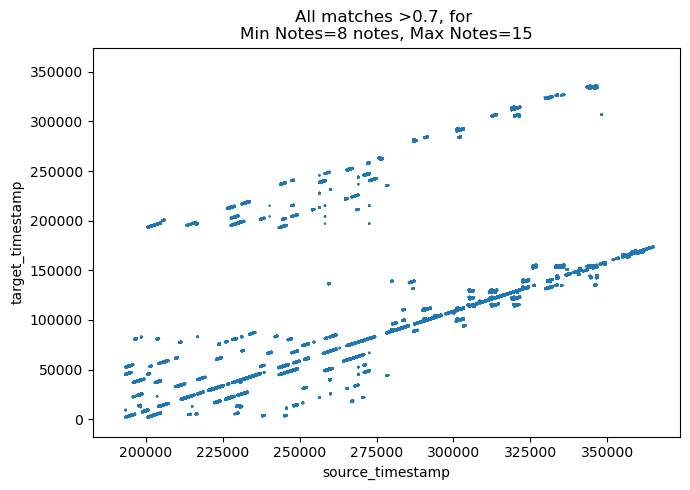

In [50]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


Percentage matches found: 98.3%
Percentage matches >0.7 found: 78.2%
Percentage matches within 50ms of line: 39.3%
Percentage matches >0.7 and within 50ms of the line: 39.3%
Minimum score of a "right match": 0.64


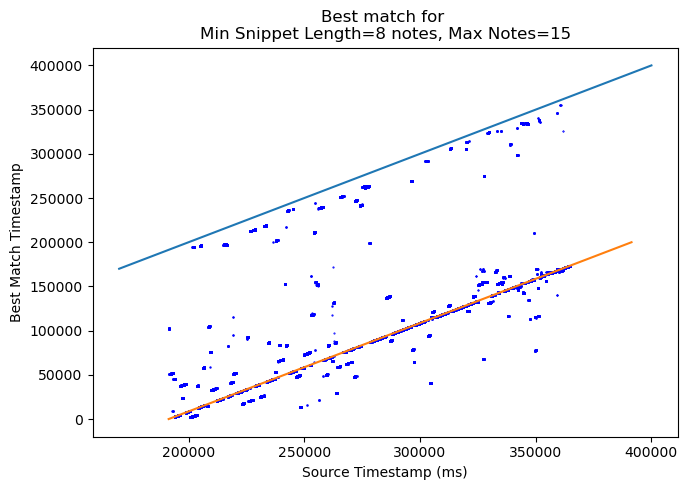

In [51]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
acc = 50                            #ms accuracy for distance from line

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True
bestMatches = []

toPlot = simsDFall
# toPlot = simsDFall_old

total = 0
distribution_hist = []
distribution_all = []
close_matches = []
min_good_score = 1
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            distribution_all.append([x,(toPlot['target_timestamp'].loc[y]-(x-191400))])
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y].tolist())
    else:
        continue
#     bestMatch = [toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],toPlot['source_id_start'].loc[y],toPlot['source_id_end'].loc[y],toPlot['target_id_start'].loc[y],toPlot['target_id_end'].loc[y]]
#     bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
# bestMatches = np.array(bestMatches)
# bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   

plt.plot(np.arange(170000,400000),np.arange(170000,400000))
plt.plot(np.arange(191400,391400),np.arange(200000))
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Timestamp")
plt.show()


In [220]:
n

3

In [212]:
data = notes[1515:1515+8][:,1]

In [213]:
h = tuple(get_hash(data, n, len(data), permutation)[0])

In [185]:
keys = list(previous_clusters.keys())
scores = [1 - cosine(cluster, h) for cluster in keys]

In [186]:
scores

[0.9978076273508656,
 0.9325352844172773,
 0.8754007185186585,
 0.9488907051639058,
 0.8665557267034658,
 0.8451718708643032,
 0.9377508559732469]

In [191]:
ind = scores.index(max(scores))
ind

0

In [201]:
snippets = list(previous_clusters[keys[ind]])

In [202]:
len(snippets)

4863

In [203]:
scores = [1 - cosine(snippet, h) for _, _, snippet in snippets] # h: hashed_source

In [204]:
list(reversed(np.argsort(scores)[-5:]))

[490, 711, 4784, 1832, 1693]

In [209]:
snippets[490][0], snippets[490][1]

(788, 9)

In [215]:
snippets[711][0], snippets[711][1]

(787, 10)

In [217]:
snippets[4784][0], snippets[4784][1]

(912, 10)

In [218]:
snippets[1832][0], snippets[1832][1]

(907, 14)

In [216]:
snippets[1693][0], snippets[1693][1]

(908, 13)

In [198]:
data

array([63, 58, 55, 58, 51, 70, 55, 58])

In [210]:
notes[788:788+9][:,1]

array([58, 58, 55, 70, 51, 58, 55, 55, 63])

In [214]:
find_from_clusters(h, 5)

[(788, 9), (787, 10), (912, 10), (907, 14), (908, 13)]

In [156]:
data

array([51, 63, 55, 58, 58, 55, 70, 51, 55, 58, 55, 63, 50, 62, 59, 55])

In [152]:
np.where(abs(notes[:,0] - 191400) < 1000)

(array([758, 759, 760, 761]),)

In [154]:
notes[755:760]

array([[171193,     55,     56],
       [172336,     60,     56],
       [172358,     72,     70],
       [191674,     51,     49],
       [191677,     63,     47]])

In [161]:
notes[1510:1518]

array([[362732,     55,     56],
       [362741,     75,     60],
       [363880,     60,     62],
       [363886,     72,     67],
       [413583,     51,     46],
       [413594,     63,     44],
       [414224,     58,     37],
       [414242,     55,     39]])

In [132]:
addToCluster(data1, 100)

In [133]:
addToCluster(data2, 101)

In [112]:
previous_clusters

{(0.5792819300549311,
  0.017784425857862687,
  0.13582186738945734,
  0.8309345058475656,
  0.3999494306967685,
  0.04850981430460316,
  0.3216284489031633,
  0.010875684477941523,
  0.016067072877949475,
  0.7059162410135207,
  0.7452482612999792,
  0.019605782081314714,
  0.5033124518679725,
  0.3923387551735851,
  0.023893955132033077,
  0.6505012091181848,
  0.3278974194187412,
  0.03573877001552488,
  0.024434642809635792,
  0.16552903522409984,
  0.06674546165381999,
  0.6071556209011668,
  0.2752643231462964,
  0.19434279046384367,
  0.4115570259848446,
  0.5675645738617374,
  0.6397360279072879,
  0.09526398146248224,
  0.30359189343579285,
  0.3988074453447379,
  0.03956717885381143,
  0.08840121370317014,
  0.530842924660195,
  0.5519799277281534,
  0.36656803943729405,
  0.5056581110283485,
  0.17155104674447424,
  0.09043982226945275,
  0.5898889115643144,
  0.018198250560159026,
  0.3151991586091907,
  0.30687659929394673,
  0.14197438633396597,
  0.48775688574660925,
  0

In [64]:
k = list(previous_clusters.keys())[0]
previous_clusters[k]

{(101, 8), 100, 8}

In [115]:
len(notes)

2992

In [125]:
data3 = notes[200:208][:,1]

In [126]:
data1, data2, data3

(array([55, 51, 67, 53, 65, 60, 56, 56]),
 array([51, 67, 53, 65, 60, 56, 56, 53]),
 array([50, 62, 55, 59, 59, 55, 50, 55]))

In [134]:
addToCluster(data3, 200)

In [135]:
len(previous_clusters.keys())

2

In [136]:
previous_clusters

{(0.5792819300549311,
  0.017784425857862687,
  0.13582186738945734,
  0.8309345058475656,
  0.3999494306967685,
  0.04850981430460316,
  0.3216284489031633,
  0.010875684477941523,
  0.016067072877949475,
  0.7059162410135207,
  0.7452482612999792,
  0.019605782081314714,
  0.5033124518679725,
  0.3923387551735851,
  0.023893955132033077,
  0.6505012091181848,
  0.3278974194187412,
  0.03573877001552488,
  0.024434642809635792,
  0.16552903522409984,
  0.06674546165381999,
  0.6071556209011668,
  0.2752643231462964,
  0.19434279046384367,
  0.4115570259848446,
  0.5675645738617374,
  0.6397360279072879,
  0.09526398146248224,
  0.30359189343579285,
  0.3988074453447379,
  0.03956717885381143,
  0.08840121370317014,
  0.530842924660195,
  0.5519799277281534,
  0.36656803943729405,
  0.5056581110283485,
  0.17155104674447424,
  0.09043982226945275,
  0.5898889115643144,
  0.018198250560159026,
  0.3151991586091907,
  0.30687659929394673,
  0.14197438633396597,
  0.48775688574660925,
  0

In [7]:
start_time = time.time()

In [8]:
end_time = time.time()

In [9]:
end_time - start_time

7.884073257446289